## PHY 411: Final Project
### Jeremy Kazimer
### jdkazime@buffalo.edu

#### _Import Statements_

To begin this portion of the project, we import the Python file I created which contains the network class and its methods.  We also import the file which contains the entropy methods:

In [1]:
import sys
sys.path.insert(1, 'utility/')

from generate_network import *
from calculate_entropy import *

Consider that an explanation of the code is partially within the .py itself, but also in the documentation on GitHub.  We can also import `numpy`, `matplotlib`, `scipy`, and `time` such that we can use their code here:

In [2]:
import time
from numpy import linspace, logspace, log2, mean, sqrt, zeros
from numpy.linalg import eigh
from matplotlib import pyplot as plt

Now, we can begin the standard procedure of creating a network:

#### _Generating Networks_

Better specification can be found in the `network_analysis.ipynb` notebook.  We are just repeating the steps there, since we cannot import data across notebooks.

In [3]:
N = 100
p = 0.25

In [4]:
G = Erdos_Renyi_GNP(N, p)

With the graph object created, we can now look at the eigenvalues and entropy:

#### _Looking at Eigenvalues_

First, note that the eigenvalues come from the linear algebra equation

\begin{equation}
\{\lambda\} = \text{det}(L - \lambda I)
\end{equation}

where $\{\lambda\}$ is the set of eigenvalues, $L$ is the Laplacian, $I$ is the identity matrix, and the det operator is the determinant of that difference.  We can then define

\begin{equation} L\vec{v}_i = \lambda_i \vec{v}_i \end{equation}

where $\vec{v}_i$ is the $i$-th eigenvector associated with the $i$-th eigenvalue, where $i \in |\{\lambda\}|$.  Solving these matrix equations results in said eigenvectors.

The analysis of the eigenvalues and eigenvectors is henceforth known as spectral analysis, something that aligns closely with principal component analysis (PCA).  In analyzing the eigenvalues, we can get a bigger picture of exactly what is going underneath the semantics of the network.  For example, it is always true that

\begin{equation}
\lambda_1 \approx 0
\end{equation}

It might not always be zero, depending on the libraries used in order to calculate the eigenvalues.  What I mean by this is that otherwise it would be a number that falls below machine precision.  In more recent developments, the number of zero eigenvalues is related to the number of communities, $k$.  That is to say

\begin{equation}
k = |\{\lambda_i: \lambda_i = 0 \text{ for } i \in |\{\lambda\}|\}|
\end{equation}

This is only really true for larger structures, the threshold indeterminate at this point.  Really, it cannot be used to pick up substructures.  Regardless, we can take a look at the histogram of the eigenvalues of our graph to get an idea: 

In [37]:
eigenvalues = G.eigenvalues

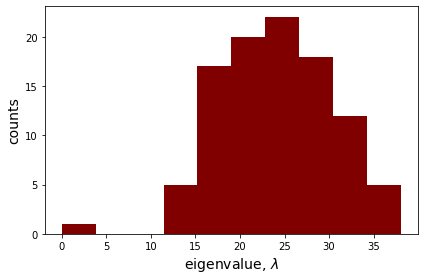

In [38]:
fig, ax = plt.subplots(1, 1)

ax.hist(eigenvalues, sqrt(N).astype(int), color = 'maroon')

ax.set_ylabel('counts', fontsize = 14)
ax.set_xlabel(r'eigenvalue, $\lambda$', fontsize = 14)

fig.tight_layout()
fig.savefig('figures/eigenvalue_distribution.png')

There are two things to note here.  The first, that there is only one $\lambda = 0$ such that there is only one community.  We can verify this via our `networkx` plot:

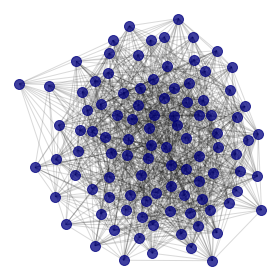

In [7]:
G.plot_networkx();

It is apparent that every node is somewhat connected to each other; there is no clear distinction between any set of nodes at this level.  Second, the average eigenvalue is

In [8]:
print('average eigenvalue: {:.2f}'.format(mean(eigenvalues)))

average eigenvalue: 24.10


If we ignore the first value, that is to say the first zero (eigenvalues are ordered ascendingly), this is more precisely: 

In [9]:
print('average eigenvalue: {:.2f}'.format(mean(eigenvalues[1:])))

average eigenvalue: 24.34


It is generally known that for the $N$ eigenvalues that there will be $N - k$ eigenvalues gravitating around the value

\begin{equation}
\bar{\lambda} \approx N \cdot p
\end{equation}

with $k$ eigenvalues at $0$.  We can verify this:

In [10]:
print('expected eigenvalue: {:.2f}'.format(N*p))

expected eigenvalue: 25.00


So, the value is close,  With more nodes this will converge even further.  That being said, the eigenvalues lead into the use of entropy:

#### _Looking at Entropy_

For the purposes of this project, we define entropy $H$ to be

\begin{equation}
H = -\sum_i p_i \log2 p_i
\end{equation}

where $p_i$ is any function such that $\sum p_i = 1$.  In this case, it is uniquely true that

\begin{equation}
\sum_i \dfrac{\lambda_i}{2M} = 1
\end{equation}

so our entropy, henceforth denoted as $H_M$, can be represented by this proportion.  Really, what this represents is the density of the matrix.  That is to say how strongly connected each node is.  Consider that earlier we defined $\lambda \approx N \cdot p$, so making a denser matrix results in higher $\{\lambda\}$ values.  As such, since $p_i \log2 p_i$ is a strictly increasing function, increasing $N$ or $p$ will result in higher entropy, thus reflecting a denser matrix.  We can see this below, by first seeing the structure of the entropy:

In [39]:
entropy = m_entropy(G)

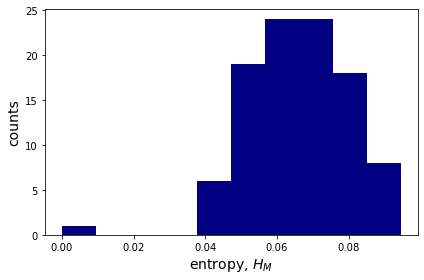

In [41]:
fig, ax = plt.subplots(1, 1)

ax.hist(entropy, sqrt(N).astype(int), color = 'navy')

ax.set_ylabel('counts', fontsize = 14)
ax.set_xlabel(r'entropy, $H_M$', fontsize = 14)

fig.tight_layout()
fig.savefig('figures/entropy_distribution.png')

It is evident that the entropy components take on a similar distribution to that of the eigenvalues, which confirms our suspicions at least in the regard that they are monotomic functions.  However, we can change $p$ over time and see that $H_M$ also increases.  We won't start at $p = 0$, since this is just going to give us an entropy of $0$, so to better reflect the structure we'll start at $p = 0.1$:

In [42]:
N = 100
ps = linspace(0.1, 1, 101)
Hms = zeros((ps.shape[0]))

In [43]:
for idx, p in enumerate(ps):
    G1 = Erdos_Renyi_GNP(N, p)
    Hms[idx] = m_entropy(G1).sum()

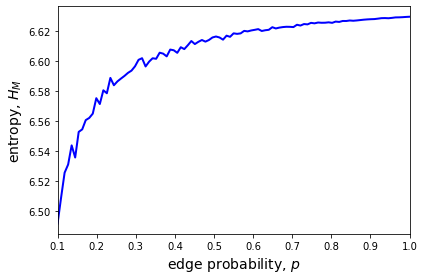

In [44]:
fig, ax = plt.subplots(1, 1)

ax.plot(ps, Hms, lw = 2, c = 'blue')

ax.set_xlim(ps[0], ps[-1])

ax.set_ylabel(r'entropy, $H_M$', fontsize = 14)
ax.set_xlabel(r'edge probability, $p$', fontsize = 14)

fig.tight_layout()

This agrees with our original proposal.  But now? We can also verify this for varying $N$, since $\lambda$ is a factor of both after all:

In [45]:
Ns = arange(10, 101)
p = 0.25
Hms = zeros((Ns.shape[0]))

In [46]:
for idx, N in enumerate(Ns):
    G1 = Erdos_Renyi_GNP(N, p)
    Hms[idx] = m_entropy(G1).sum()

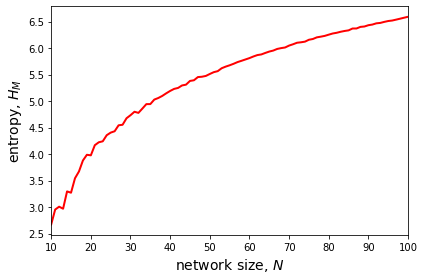

In [47]:
fig, ax = plt.subplots(1, 1)

ax.plot(Ns, Hms, lw = 2, c = 'red')

ax.set_xlim(Ns[0], Ns[-1])

ax.set_ylabel(r'entropy, $H_M$', fontsize = 14)
ax.set_xlabel(r'network size, $N$', fontsize = 14)

fig.tight_layout()

Interestingly, the function is a bit smoother, but it has the same general shape.  This is really that of the form of entropy - this is a $-xlogx$ function.  Regardless, we can also introduce $H_{\beta}$, a new type of entropy recently validated.  This has a probability function
\begin{equation}
p_i = \dfrac{e^{-\beta \lambda_i}}{Z}
\end{equation}

where $\beta$ is a time-scale parameter on $\beta \geq 0$ and $Z$ is the thermodynamic partition function as defined by
\begin{equation}
Z = \sum_j e^{-\beta \lambda_j}
\end{equation}

Note that $i$ and $j$ are different indices here.  Either way, this entropy model is more so for detecting the number of subgraphs that a graph has - that is to say, the community structure.  So, for a typical $G_{NP}$ this doesn't mean much.  However, we can still repeat the process from above.  For now, we'll work with $\beta = 1$, but soon we'll show what each one does differently.

In [48]:
N = 100
ps = linspace(0.1, 1, 101)
Hbs = zeros((ps.shape[0]))

In [49]:
for idx, p in enumerate(ps):
    G1 = Erdos_Renyi_GNP(N, p)
    Hbs[idx] = b_entropy(G1).sum()

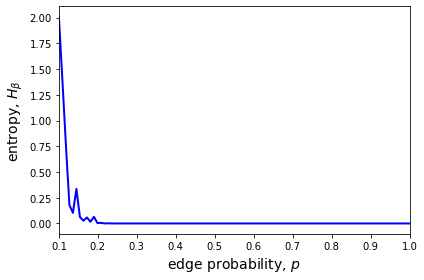

In [50]:
fig, ax = plt.subplots(1, 1)

ax.plot(ps, Hbs, lw = 2, c = 'blue')

ax.set_xlim(ps[0], ps[-1])

ax.set_ylabel(r'entropy, $H_\beta$', fontsize = 14)
ax.set_xlabel(r'edge probability, $p$', fontsize = 14)

fig.tight_layout()

Interestingly, this is almost opposite to what we observe before...basically, as a matrix becomes more dense the community structure is easier to peel apart.  We can show something different for varying $N$:

In [51]:
Ns = arange(10, 101)
p = 0.25
Hbs = zeros((Ns.shape[0]))

In [52]:
for idx, N in enumerate(Ns):
    G1 = Erdos_Renyi_GNP(N, p)
    Hbs[idx] = m_entropy(G1).sum()

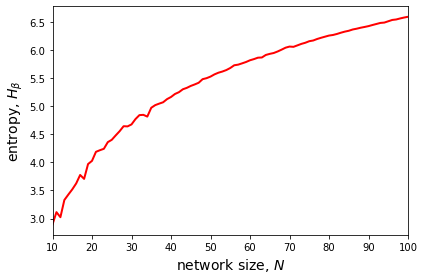

In [53]:
fig, ax = plt.subplots(1, 1)

ax.plot(Ns, Hbs, lw = 2, c = 'red')

ax.set_xlim(Ns[0], Ns[-1])

ax.set_ylabel(r'entropy, $H_\beta$', fontsize = 14)
ax.set_xlabel(r'network size, $N$', fontsize = 14)

fig.tight_layout()

This is still the same.  Which makes sense, I suppose, in the regard that the matrix is actually getting sparser, but the eigenvalues are increasing, so the exponent in $p_i$ can be treated as a small angle approximation such that
\begin{equation}
p_i \approx \dfrac{-\beta \lambda_i}{Z} = \dfrac{\lambda_i}{2M}
\end{equation}

such that
\begin{equation}
Z \approx \sum_j -\beta \lambda_j = -\beta 2M
\end{equation}

This is why, when we make comparisons like this, we really only vary edge probability.  If we want to vary network size, we have a set node degree so that probability is actively changing.  Nevertheless, how does $\beta$ affect all of this? Since varying the edge probability is the most telling graph of the two, we can repeat this for different $\beta$:

In [54]:
N = 100
ps = linspace(0.1, 1, 101)
betas = logspace(-2, 1, 101)
Hbs = zeros((ps.shape[0], betas.shape[0]))

In [55]:
for idx, p in enumerate(ps):
    for jdx, beta in enumerate(betas):
        G1 = Erdos_Renyi_GNP(N, p)
        Hbs[idx, jdx] = b_entropy(G1, beta = beta).sum()

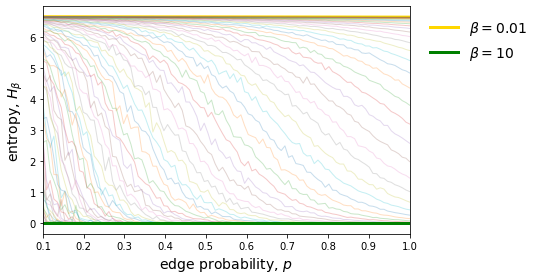

In [56]:
fig, ax = plt.subplots(1, 1)

ax.plot(ps, Hbs[:, 0], lw = 3, c = 'gold', label = r'$\beta = 0.01$')
ax.plot(ps, Hbs[:, 1:-2], lw = 1, alpha = 0.25)
ax.plot(ps, Hbs[:, -1], lw = 3, c = 'green', label = r'$\beta = 10$')

ax.set_xlim(ps[0], ps[-1])

ax.set_ylabel(r'entropy, $H_\beta$', fontsize = 14)
ax.set_xlabel(r'edge probability, $p$', fontsize = 14)

fig.legend(bbox_to_anchor = [1.25, 0.95], fontsize = 14, frameon = False)

fig.tight_layout()
fig.savefig('figures/entropy_vs_beta.png')

This is pretty interesting, actually.  Notice that the lines begin horizontal but gradually begin to plummet downwards as $\beta$ increases.  But it makes sense.  Let's start with the case where $\beta = 0.1$, or generally that $\beta$ is small.   When this is the case, the value of the eigenvalues don't really matter.  The smaller that $\beta$ gets, the closer that $-\beta \lambda_i$ approaches zero.  When this is zero, then the exponent just evaluates to $1$.  So, as $\beta$ approaches zero the entropy approaches its maximal value, when $p_i$ is the same everywhere.  

Since all the terms would just be $1$, the value of $Z$ would then just be $N$ such that
\begin{equation}
p_i = \dfrac{1}{N}
\end{equation}

such that the entropy would converge to
\begin{equation}
H_{\beta} \approx -\sum_i \dfrac{1}{N} \log_2 \dfrac{1}{N} = \log_2 N
\end{equation}

after some simplifcations.  Namely, that there are $N$ eigenvalues.  We can actually show this!

In [57]:
print('approximation error: {}'.format(abs(Hbs[-1, 0] - log2(N))))

approximation error: 0.013975051799810956


So, it's pretty close.  The main consideration here is that $\beta = 0.01$ isn't as small as it could be.  When $\beta = 0$, this approximation will be spot on.  Now, the other case, for $\beta = 10$ or simply when $\beta$ is large...well, what this causes to happen is that, for large networks, almost all of the exponentiation vanishes since $e^{-\beta \lambda_i}$ for a large $-\beta \lambda_i$ is approximately zero.  Consider that our entropy isn't zero, though.  At least, for small probabilities:

In [58]:
print('entropy at p = {}: H = {}'.format(ps[0], Hbs[0, -1]))

entropy at p = 0.1: H = 5.9536614236886085e-09


So, what gives? Well, there are still eigenvalues that linger around $\lambda_i = 0$ for a $G_{NP}$.  Namely, there are $N - k$ eigenvalues, as mentioned previously, that are nonzero and $k$ eigenvalues that are zero.  So, $N - k$ of the contributions are approximately nothing, but there are those residual $k$ eigenvalues that have some contribution, as minor as they may be.  

Effectively, in the limit of large $\beta$, the only eigenvalues that matter are those that hover around $\lambda_i = 0$, at least for a $G_{NP}$.  So, this explains why the entropy is not quite zero at all locations.  This is what the entropy model is great for! Large $\beta$ effectively nullifies the normal eigenvalue distribution and instead we focus exclusively on the smallest eigenvalues.  So, in detecting communities, this disregards the normal noise from strongly connected $G_{NP}$'s, but instead zoning in on the eigenvalues representing the number of subgraphs.

Nevertheless, we can transition away from a static graph and instead investigate dynamic modifications to the graph, namely rewiring:

#### _Looking at Rewiring_

Rewiring is really the process of moving an edge from one location to the other.  As such, the number of edges will remain the same throughout the entire process.  Therefore, it would follow that the eigenvalues and subsequently entropy will remain vaguely the same.  The only variations then would come from the ordering of the adjacency matrix, as opposed to the input parameters.\\\

To demonstrate this, we can calculate the entropy after each rewire.  We can also store the eigenvalues (ignoring the first, since this is uniquely zero) and seeing how this evolves over time:

In [59]:
rewires = 1000
Hs = zeros((rewires + 1))
avg_eigs = zeros((rewires + 1, N - 1))

In [60]:
for rewire in range(rewires + 1):
    Hs[rewire] = m_entropy(G).sum()
    avg_eigs[rewire] = G.eigenvalues[1:]
    
    G.rewire_graph()

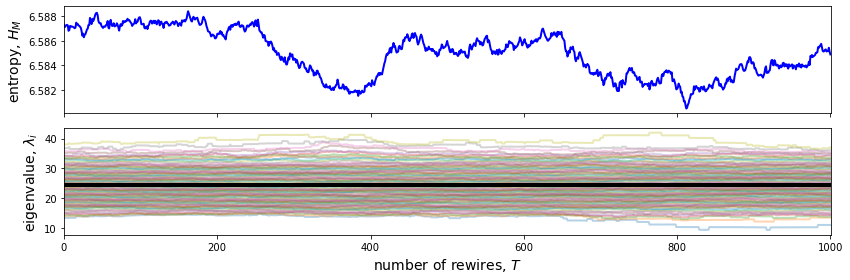

In [61]:
fig, axs = plt.subplots(2, 1, figsize = (12, 4), sharex = True)

axs[0].plot(range(rewires + 1), Hs, lw = 2, c = 'blue')

axs[0].set_xlim(0, rewires + 1)

axs[0].set_ylabel(r'entropy, $H_M$', fontsize = 14)


axs[1].plot(range(rewires + 1), avg_eigs, lw = 2, alpha = 0.33)
axs[1].plot(range(rewires + 1), avg_eigs.mean(axis = 1), lw = 4, c = 'k')

axs[1].set_xlim(0, rewires + 1)

axs[1].set_ylabel(r'eigenvalue, $\lambda_i$', fontsize = 14)
axs[1].set_xlabel(r'number of rewires, $T$', fontsize = 14)

fig.tight_layout()

See that the entropy over time appears like a Markov Chain Monte Carlo random walk.  In order to show this, I would need to be able to copy the network, which I am unable to do currently.  If a bunch of rewires were plotted on the same graph, this would be more apparent.  

Regardless, the black line on the eigenvalues graph is actually the average eigenvalue, $\bar{\lambda_i}$.  So, what this shows is that the average eigenvalue doesn't actually change for this type of rewiring.  For now, this is all that can really be shown for this type of entropy.  However, with the implementation of $H_\beta$, the whole landscape of this application changes...soon.  

Now, we can time some of the function and test it so that it's apparent this is working.

#### _Timing Code_

The main thing here to time would be calculating entropy.  So, we can do this by rewiring and then calculating the entropy of each new configuration.  During all of this, it will be timed.

In [62]:
ts = zeros((rewires))

for rewire in range(rewires):
    G.rewire_graph()
    t0 = time.time()
    m_entropy(G)
    ts[rewire] = time.time() - t0

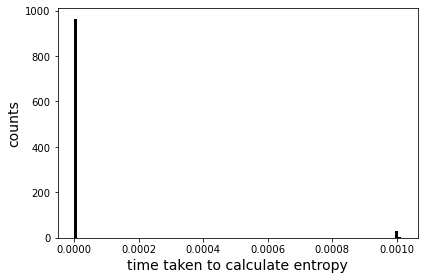

In [63]:
fig, ax = plt.subplots(1, 1)

ax.hist(ts, 100, color = 'black');

ax.set_ylabel('counts', fontsize = 14)
ax.set_xlabel('time taken to calculate entropy', fontsize = 14)

fig.tight_layout()

Basically, due to `numpy`'s vectorization, this effectively took no time.  But wait, the iterations weren't instant, so what's up with that? The reality is that the main computational expense actually comes from re-calculating the eigenvalues each time, which is done under the new rewiring function.  We can, without iterating directly, time this as well:

In [64]:
%timeit -r 100 -n 10 eigh(G.L)

660 µs ± 126 µs per loop (mean ± std. dev. of 100 runs, 10 loops each)


And now repeating, but for calculating the entropy:

In [65]:
%timeit -r 100 -n 10 m_entropy(G)

The slowest run took 4.25 times longer than the fastest. This could mean that an intermediate result is being cached.
9.89 µs ± 2.36 µs per loop (mean ± std. dev. of 100 runs, 10 loops each)


As such, this is approximately 150 times slower to calculate the eigenvalues.  So, rewiring, although a necessary process, is time consuming.  Now, imagine this for networks with size $N > 1000$ $\dots$